In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-128.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-007.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-086.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-142.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-129.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-088.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-021.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPHMX8000C3403.2120.00000099.7579.01.25-26250/1-092.dcm
/kaggle/input/ct-heart-segmentation/data/test/100258/5361-0OPAPH

In [2]:
import numpy as np
import tensorflow as tf
import os
import cv2
import glob as gb
from tqdm import tqdm
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input , BatchNormalization, Dropout ,Conv2DTranspose


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

In [4]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
    input_image = input_image / 255.0
    input_mask = input_mask / 255.0
    return input_image, input_mask

In [6]:
def load_data(train_dir):
    X=[]
    Y=[]

    for folder in tqdm(os.listdir(train_dir)):
        folder_path = os.path.join(train_dir, folder)

        if not os.path.isdir(folder_path):
            continue

        # Load images
        image_files = sorted(gb.glob(os.path.join(folder_path, 'image', '*.png')))
        for file in image_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to load image {file}")
                continue
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
            X.append(img)

        # Load masks
        mask_files = sorted(gb.glob(os.path.join(folder_path, 'mask', '*.png')))
        for file in mask_files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to load mask {file}")
                continue
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) 
            Y.append(img)
    X = np.array(X)
    Y = np.array(Y)
    X,Y = normalize(X,Y)
     
    # Split the data
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size= int(len(X)*0.2), random_state=42 , shuffle = True)
    x_train, y_train = augment(x_train, y_train)
        
    return  x_train, x_valid, y_train, y_valid

In [7]:
x_train, x_valid, y_train, y_valid = load_data('/kaggle/input/ct-heart-segmentation/data/train')

100%|██████████| 19/19 [00:38<00:00,  2.01s/it]


In [8]:
#X= load_data('/kaggle/input/ct-heart-segmentation/data/train')
#y= load_data('/kaggle/input/ct-heart-segmentation/data/test')

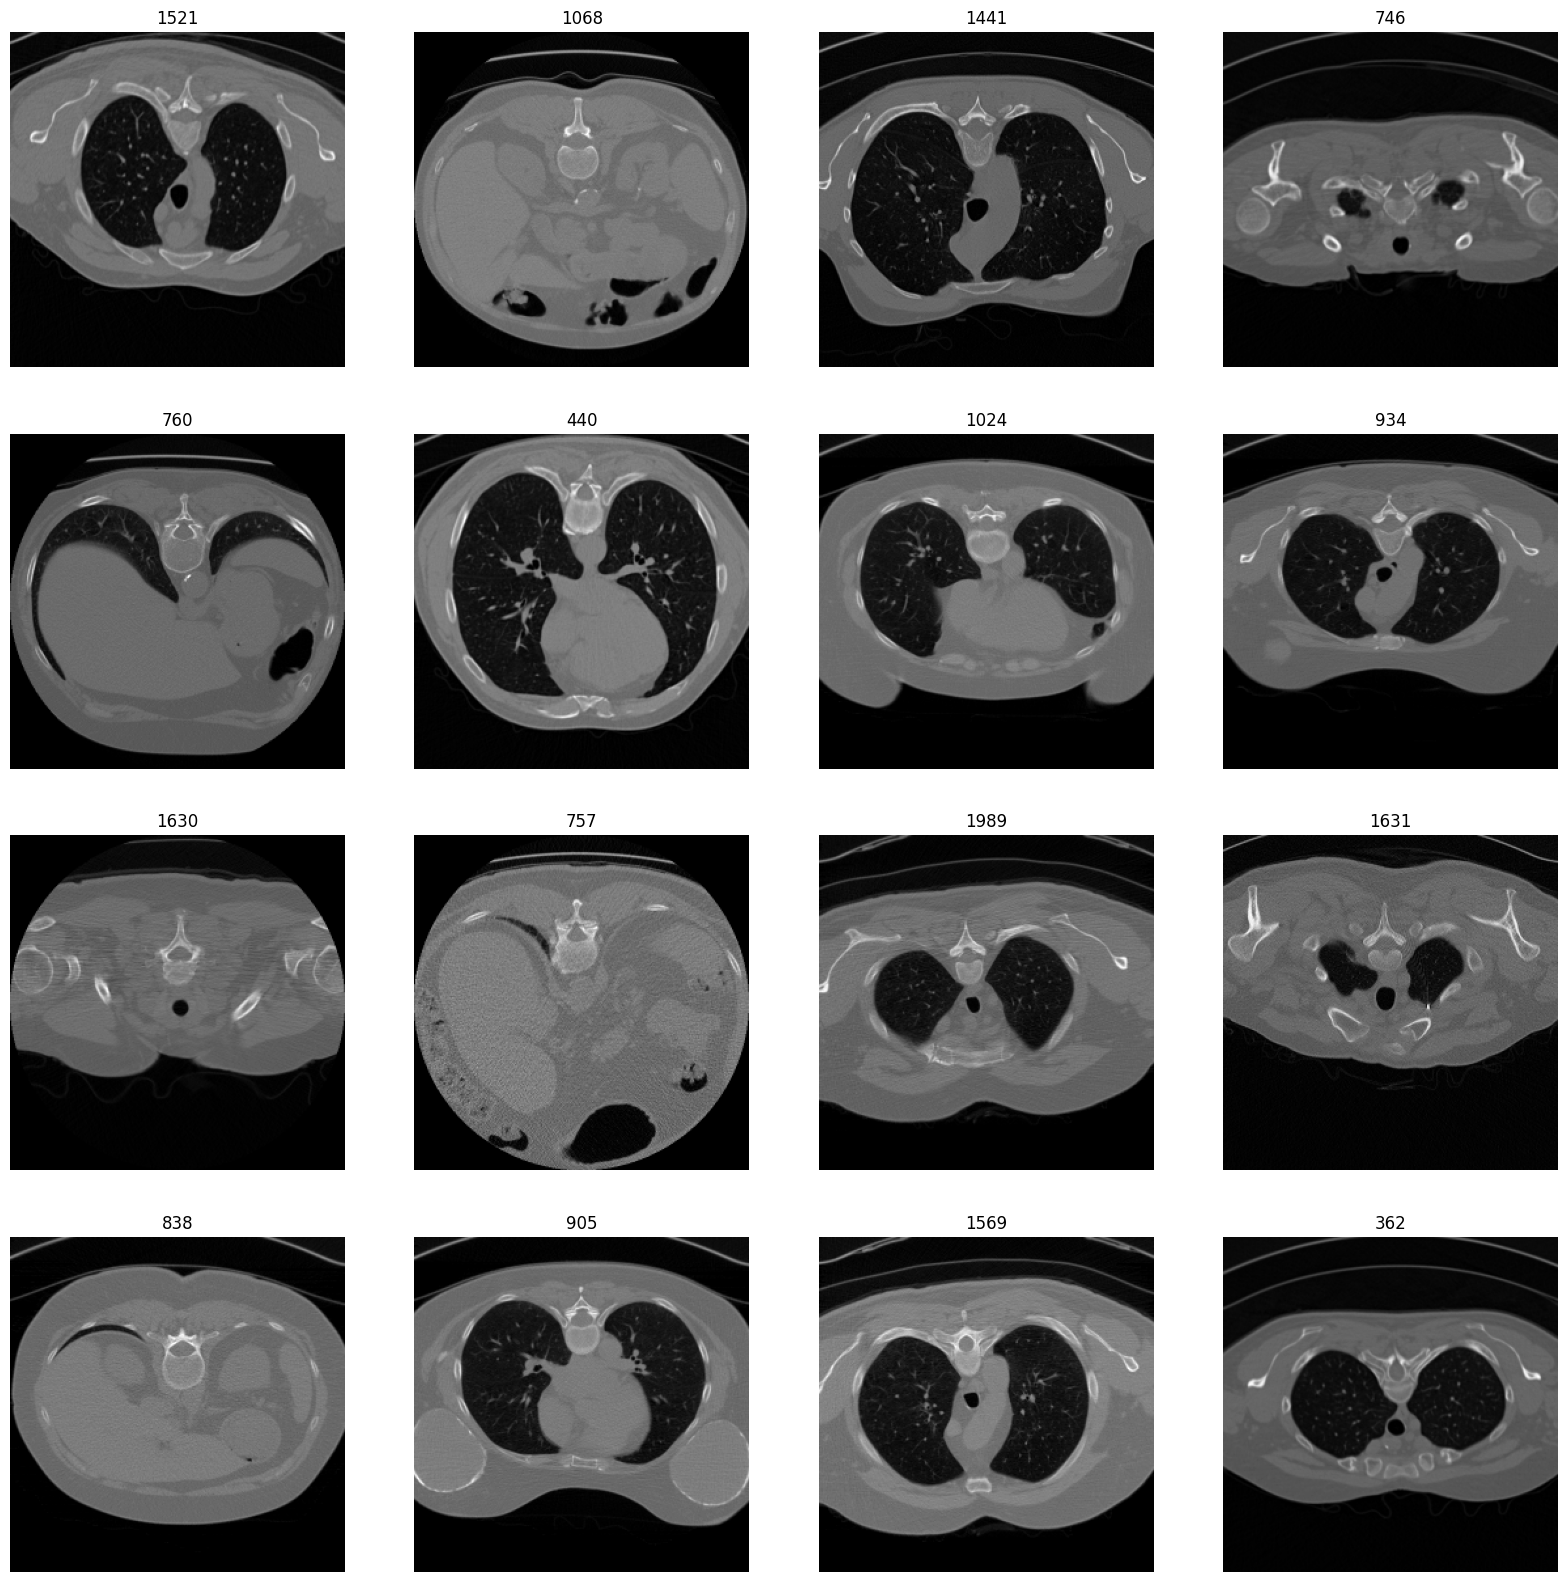

In [9]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(x_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [10]:
num_classes = 1

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [11]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(x_train, y_train, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25


I0000 00:00:1730805532.142995      67 service.cc:145] XLA service 0x7f0bb8069880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730805532.143049      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730805532.143053      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730805552.287495      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - accuracy: 0.9583 - loss: 0.2293
Epoch 2/25
  1/127 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.9864 - loss: 0.0648

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9888 - loss: 0.0523
Epoch 3/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.9910 - loss: 0.0326
Epoch 4/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9918 - loss: 0.0254
Epoch 5/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9927 - loss: 0.0206
Epoch 6/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9933 - loss: 0.0183
Epoch 7/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9936 - loss: 0.0167
Epoch 8/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9940 - loss: 0.0151
Epoch 9/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9949 - loss: 0.0127
Epoch 10/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.9946 - loss: 0.0134
Epoch 11/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.9955 - loss: 0.0110
Epoch 12/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.9953 - loss: 0.0111
Epoch 13/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/st

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 20%|██        | 1/5 [00:01<00:06,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 3/5 [00:01<00:00,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 5/5 [00:02<00:00,  2.38it/s]


Image 279 - Acc: 0.96, F1: 0.00, Jaccard: 0.00, Recall: 0.00, Precision: 1.00
Image 480 - Acc: 1.00, F1: 0.00, Jaccard: 0.00, Recall: 1.00, Precision: 0.00
Image 15 - Acc: 0.93, F1: 0.29, Jaccard: 0.17, Recall: 0.17, Precision: 0.86
Image 87 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00
Image 197 - Acc: 1.00, F1: 1.00, Jaccard: 1.00, Recall: 1.00, Precision: 1.00


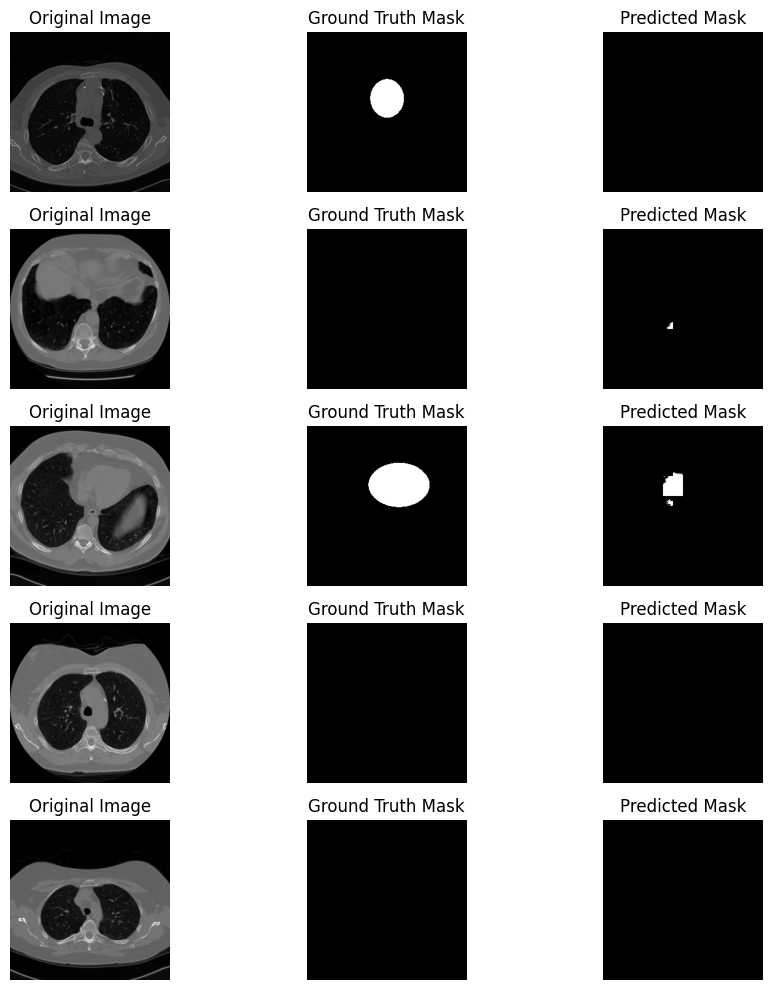

In [13]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

H = 256
W = 256

# Load the dataset
test_x = x_valid  
test_y = y_valid

# Randomly select 5 indices without fixing the seed
random_indices = np.random.choice(len(test_x), size=5, replace=False)

SCORE = []
examples = []  # To store example images for display

for idx in tqdm(random_indices):
    x = test_x[idx]  # Get the selected image
    y = test_y[idx]  # Get the corresponding mask

    image = x  # x is already the image (normalized)
    x = np.expand_dims(image, axis=0)  # Add batch dimension

    # Ensure the mask is binary
    mask = (y > 0.5).astype(np.int32)

    # Prediction
    y_pred = model.predict(x)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = (y_pred > 0.5).astype(np.int32)  # Convert to binary

    # Store the image, mask, and prediction for display
    examples.append((image, mask, y_pred))

    # Flatten the arrays for metrics
    y_flat = mask.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculating the metrics values
    acc_value = accuracy_score(y_flat, y_pred_flat)
    f1_value = f1_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    jac_value = jaccard_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    recall_value = recall_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    precision_value = precision_score(y_flat, y_pred_flat, labels=[0, 1], average="binary", zero_division=1)
    
    SCORE.append([f"Image {idx + 1}", acc_value, f1_value, jac_value, recall_value, precision_value])

# Print all SCORE values
for score in SCORE:
    print(f"{score[0]} - Acc: {score[1]:.2f}, F1: {score[2]:.2f}, Jaccard: {score[3]:.2f}, Recall: {score[4]:.2f}, Precision: {score[5]:.2f}")

# Plotting the results
plt.figure(figsize=(10, 10))
for i, (img, mask, pred) in enumerate(examples):
    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()